# Question_1 : The MPL regressor for Modeling_Reactive_Ion_Plasma_Etching_Process <br>
The purpose of this study is to predict the behaviur of four outcomes  "U", "Rp" , "Sox" and "Sph" which respectively are called output 1 to 4 in this study.<br>
As they are assumed be independent outcomes , different regressor trained for each of them and their hyper parameter and their structure could be totally different. So, prediction for mentioned outcomes consists of 4 major steps: <br>
1- Data Reading and Preprocessing <br>
2-Training and cross_validation <br>
3-Visualization and analysis <br>
4-Hyper parameter Tuning (learning rate, NN structure, optimizer , etc)<br>
<br>

    

# Importing required Packages 

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf 
from sklearn.model_selection import LeaveOneOut
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image

## Data Reading and Normalizing <br>
> With pandas package, data is read and standardized.  


In [ ]:
dataset = pd.read_csv('Modeling_Reactive_Ion_Plasma_Etching_Process.csv')
dataset = dataset.iloc[:,1:]  # droppin the 'Run' column

# Normalizing the data 
dataset = (dataset-dataset.mean())/dataset.std() 

# getting the variuance of shared co-ordinates in order to avoid overfitting and also early stop for training
grouped = dataset.groupby(['Pressure', 'RF Power', 'Electrode\nGap', 
                           'CCl4 Flow', 'He Flow','O2\nFlow']).agg({'size','var'})
grouped.columns=["_".join(x) for x in grouped.columns.ravel()] 

permitted_variance = {'Rp _var': np.max(grouped['Rp _var']),
                      ' U_var' : np.max(grouped[' U_var']),
                       'Sox_var': np.max(grouped['Sox_var']),
       'Sph_var':np.max(grouped['Sph_var'])}

# Network structuring <br>
> It 's always been a good idea to develop a messy regressor/classifier at the first step to see what is the result and get the idea over the datasets and out puts. Hence our dataset is small in size and very parse (except of 8 co-ordinates) , it would not be a very good idea to train a very deep network and have a network with quite large capacity of learning. However, those shared coordinates could give us some precious information about what the generalization error should be. At the first step, the NN trained to the end of epoch range however later on , the early stop is put for training. The reason will explian on trainng and cross validation sesction . The "permitted_variance" dictionary is showing the allawable variance for each out put and we could consider it as an accepatable generalization error. <br>

> In this study two network , 3 layers and 5 layers were in to examination. However, the number of neurons for the deeper model is less relative to the shallower one. However , Network structure could be considered a hyper parameter and gridy or random search could be applied, just these two NNs were tested and the better one is chosen and the other hyperparameters were tuned on the chosen one. 

In [ ]:
graph_3layer = tf.Graph()
with graph_3layer.as_default():
    with tf.name_scope('INPUT'):
        regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)
        X = tf.placeholder (tf.float32,shape=(None,6), name= "input_x")
        labels = tf.placeholder (tf.float32,shape=(None,1), name= "labels")
    with tf.name_scope('layer_1'):
        layer_1  = tf.layers.dense(X ,units=10, activation= tf.nn.leaky_relu , use_bias=True , 
                           kernel_regularizer=regularizer )
        dropout_1 = tf.layers.dropout(layer_1,rate=0.5 , name='dropout_1')
        
    with tf.name_scope('layer_2'):
        layer_2  = tf.layers.dense(dropout_1, units= 5,activation= tf.nn.leaky_relu , use_bias=True , 
                           kernel_regularizer=regularizer )
        dropout_2 = tf.layers.dropout(layer_2, rate=.5 , name='dropout_2')
        
    with tf.name_scope('prediction'):
        output = tf.layers.dense(dropout_2, units=1 , use_bias=True , kernel_regularizer=regularizer)
        
    with tf.name_scope('Optimization_Loss'):
        Loss = tf.losses.mean_squared_error(output,labels)
        optimizer = tf.train.AdamOptimizer(learning_rate=.01,beta1=.9,beta2=.999, 
                                      epsilon=1e-08,name='Adam').minimize(Loss)
        tf.summary.scalar('Loss', Loss)
        

graph_3layer_Relu = tf.Graph()
with graph_3layer_Relu.as_default():
    with tf.name_scope('INPUT'):
        regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)
        X = tf.placeholder (tf.float32,shape=(None,6), name= "input_x")
        labels = tf.placeholder (tf.float32,shape=(None,1), name= "labels")
    with tf.name_scope('layer_1'):
        layer_1  = tf.layers.dense(X ,units=10, activation= tf.nn.relu , use_bias=True , 
                           kernel_regularizer=regularizer )
        dropout_1 = tf.layers.dropout(layer_1,rate=0.5 , name='dropout_1')
        
    with tf.name_scope('layer_2'):
        layer_2  = tf.layers.dense(dropout_1, units= 5,activation= tf.nn.relu , use_bias=True , 
                           kernel_regularizer=regularizer )
        dropout_2 = tf.layers.dropout(layer_2, rate=.5 , name='dropout_2')
        
    with tf.name_scope('prediction'):
        output = tf.layers.dense(dropout_2, units=1 , use_bias=True , kernel_regularizer=regularizer)
        
    with tf.name_scope('Optimization_Loss'):
        Loss = tf.losses.mean_squared_error(output,labels)
        optimizer = tf.train.AdamOptimizer(learning_rate=.01,beta1=.9,beta2=.999, 
                                      epsilon=1e-08,name='Adam').minimize(Loss)
        tf.summary.scalar('Loss', Loss)

graph_3layer_NoDropOut = tf.Graph()
with graph_3layer_NoDropOut.as_default():
    with tf.name_scope('INPUT'):
        regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)
        X = tf.placeholder (tf.float32,shape=(None,6), name= "input_x")
        labels = tf.placeholder (tf.float32,shape=(None,1), name= "labels")
    with tf.name_scope('layer_1'):
        layer_1  = tf.layers.dense(X ,units=10, activation= tf.nn.leaky_relu , use_bias=True , 
                           kernel_regularizer=regularizer )
        #dropout_1 = tf.layers.dropout(layer_1,rate=0.5 , name='dropout_1')
        
    with tf.name_scope('layer_2'):
        layer_2  = tf.layers.dense(layer_1, units= 5,activation= tf.nn.leaky_relu , use_bias=True , 
                           kernel_regularizer=regularizer )
        #dropout_2 = tf.layers.dropout(layer_2, rate=.5 , name='dropout_2')
        
    with tf.name_scope('prediction'):
        output = tf.layers.dense(layer_2, units=1 , use_bias=True , kernel_regularizer=regularizer)
        
    with tf.name_scope('Optimization_Loss'):
        Loss = tf.losses.mean_squared_error(output,labels)
        optimizer = tf.train.AdamOptimizer(learning_rate=.01,beta1=.9,beta2=.999, 
                                      epsilon=1e-08,name='Adam').minimize(Loss)
        tf.summary.scalar('Loss', Loss)

graph_2layer = tf.Graph()
with graph_2layer.as_default():
    with tf.name_scope('INPUT'):
        regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)
        X = tf.placeholder (tf.float32,shape=(None,6), name= "input_x")
        labels = tf.placeholder (tf.float32,shape=(None,1), name= "labels")
        
    with tf.name_scope('layer_1'):
        layer_1  = tf.layers.dense(X ,units=10, activation= tf.nn.leaky_relu , use_bias=True , 
                           kernel_regularizer=regularizer )
        dropout_1 = tf.layers.dropout(layer_1,rate=0.5 , name='dropout_1')
    with tf.name_scope('prediction'):
        output = tf.layers.dense(dropout_1, units=1 , use_bias=True , kernel_regularizer=regularizer)
        
    with tf.name_scope('Optimization_Loss'):
        Loss = tf.losses.mean_squared_error(output,labels)
        optimizer = tf.train.AdamOptimizer(learning_rate=.01,beta1=.9,beta2=.999, 
                                      epsilon=1e-08,name='Adam').minimize(Loss)
        tf.summary.scalar('Loss', Loss)   
        
graph_5layer = tf.Graph()
with graph_5layer.as_default():
    with tf.name_scope('INPUT'):
        regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)
        X = tf.placeholder (tf.float32,shape=(None,6), name= "input_x")
        labels = tf.placeholder (tf.float32,shape=(None,1), name= "labels")
    with tf.name_scope('layer_1'):
        layer_1  = tf.layers.dense(X ,units=10, activation= tf.nn.leaky_relu , use_bias=True , 
                           kernel_regularizer=regularizer )
        dropout_1 = tf.layers.dropout(layer_1,rate=0.5 , name='dropout_1')
        
    with tf.name_scope('layer_2'):
        layer_2  = tf.layers.dense(dropout_1, units= 20,activation= tf.nn.leaky_relu , use_bias=True , 
                           kernel_regularizer=regularizer )
        dropout_2 = tf.layers.dropout(layer_2, rate=.5 , name='dropout_2')
        
    with tf.name_scope('layer_3'):
        layer_3  = tf.layers.dense(dropout_2, units= 10,activation= tf.nn.leaky_relu , use_bias=True , 
                           kernel_regularizer=regularizer )
        dropout_3 = tf.layers.dropout(layer_3, rate=.5 , name='dropout_2')
    
    with tf.name_scope('layer_4'):
        layer_4  = tf.layers.dense(dropout_3, units= 5,activation= tf.nn.leaky_relu , use_bias=True , 
                           kernel_regularizer=regularizer )
        dropout_4 = tf.layers.dropout(layer_4, rate=.5 , name='dropout_2')
        
    with tf.name_scope('prediction'):
        output = tf.layers.dense(dropout_4, units=1 , use_bias=True , kernel_regularizer=regularizer)
        
    with tf.name_scope('Optimization_Loss'):
        Loss = tf.losses.mean_squared_error(output,labels)
        optimizer = tf.train.AdamOptimizer(learning_rate=.01,beta1=.9,beta2=.999, 
                                      epsilon=1e-08,name='Adam').minimize(Loss)
        tf.summary.scalar('Loss', Loss)

graph_5layer_Relu = tf.Graph()        
with graph_5layer_Relu.as_default():
    with tf.name_scope('INPUT'):
        regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)
        X = tf.placeholder (tf.float32,shape=(None,6), name= "input_x")
        labels = tf.placeholder (tf.float32,shape=(None,1), name= "labels")
    with tf.name_scope('layer_1'):
        layer_1  = tf.layers.dense(X ,units=10, activation= tf.nn.relu , use_bias=True , 
                           kernel_regularizer=regularizer )
        dropout_1 = tf.layers.dropout(layer_1,rate=0.5 , name='dropout_1')
        
    with tf.name_scope('layer_2'):
        layer_2  = tf.layers.dense(dropout_1, units= 20,activation= tf.nn.relu , use_bias=True , 
                           kernel_regularizer=regularizer )
        dropout_2 = tf.layers.dropout(layer_2, rate=.5 , name='dropout_2')
        
    with tf.name_scope('layer_3'):
        layer_3  = tf.layers.dense(dropout_2, units= 10,activation= tf.nn.relu , use_bias=True , 
                           kernel_regularizer=regularizer )
        dropout_3 = tf.layers.dropout(layer_3, rate=.5 , name='dropout_2')
    
    with tf.name_scope('layer_4'):
        layer_4  = tf.layers.dense(dropout_3, units= 5,activation= tf.nn.relu , use_bias=True , 
                           kernel_regularizer=regularizer )
        dropout_4 = tf.layers.dropout(layer_4, rate=.5 , name='dropout_2')
        
    with tf.name_scope('prediction'):
        output = tf.layers.dense(dropout_4, units=1 , use_bias=True , kernel_regularizer=regularizer)
        
    with tf.name_scope('Optimization_Loss'):
        Loss = tf.losses.mean_squared_error(output,labels)
        optimizer = tf.train.AdamOptimizer(learning_rate=.01,beta1=.9,beta2=.999, 
                                      epsilon=1e-08,name='Adam').minimize(Loss)
        tf.summary.scalar('Loss', Loss)

> The network above is just a sample of fully connected 3 layer network with drop out with rate 50 percent following after each dense layer and it is called **"graph_3layer"** . Similarly **"graph_5layer", "graph_3layer_NoDrop", "graph_5layer_NoDrop"** developed and put on the examination. Again, The "Drop Out Rate" could be another hyperparameter to tune but here for the sake of computation it is just kept at 50 percent.  

> For now , let's focus on graph_3Layer which has two dense layers with Drop out layer afterwards and the third layer is just fully conncetd layer with linear regresision . 

> The visualization utilizing **tensorboard** will help to undersatnd the structure of network especially working with some very deep networks. Wiith name scope in structuring the graph we could get a neat visualization of the network. Also, In order to have the value of loss in each trainng , optimization and test  I added tf.summary.scalar to collect the loss for furthur report within tensorboard platform. Below the shape of the network (for jusst 3layer with dropout ) is shown. 

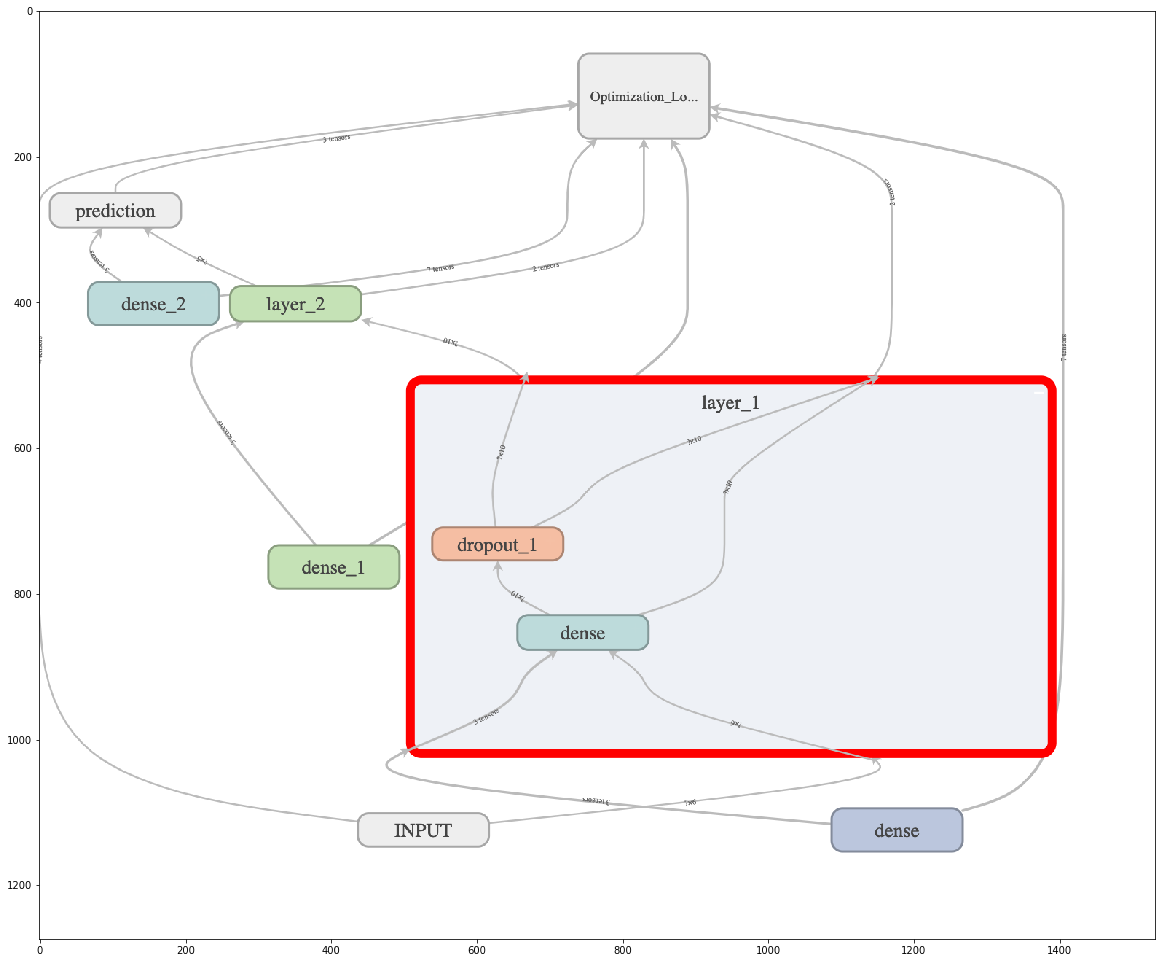

In [ ]:
fig = plt.figure(figsize=(20,20))
image = mpimg.imread("3layer_graph.png")
plt.imshow(image)
plt.show()

# Cross Validation <br>
> As our dataset is only 54 data points and they are the result of the experimental design **LEAVE ONE OUT** approach is used for cross validation to have each data point bounced against our predictor (NN). And It could be done by calling **"LeavOneOut"** from sklearn package. 

In [ ]:
loo = LeaveOneOut()

# Training and Testing Algorithm <br>
>The main scope of hyper parameter tuning of this study is network structure and 6 network structures were tested within one leave out (all vs one) cross validation and the best structure would be determined based on the result. Because it is the small dataset , **Batch optimization** is utilized.  The block for training and collectiong summary results is shown blow, Just it needs to have the proper graph name in its Session argument. In each run it collects the summaries of loss for each training and validate set in to graph_train and graph_test and tensorboard would be able to show the results in one graph.

In [ ]:
# befor run , you need to feed the graph name . In order to train for different outcomes , you need to feed the proper column 
dic= {}
with tf.Session(graph=graph_name) as sess:
        writer_1 = tf.summary.FileWriter('./graphs_train', sess.graph)
        writer_2 = tf.summary.FileWriter('./graphs_test', sess.graph)
        summary_op = tf.summary.merge_all()
        i=1
        train_loss=[]
        CV_loss = []
        for train,test in loo.split(dataset):
            Input_train= np.array(dataset.iloc[train] , dtype= 'float32')[:,:6] 
            Optput_train = np.array(dataset.iloc[train] , dtype= 'float32')[:,6]# feed the proper column ; this is for the fisrt outcome.
            Optput_train = Optput_train.reshape((-1,1))
            Input_test = np.array(dataset.iloc[test] , dtype= 'float32')[:,:6]
            Optput_test = np.array(dataset.iloc[test] , dtype= 'float32')[:,6]# feed the proper column (7,8,9) ; this is for the fisrt outcome.
            Optput_test = Optput_test.reshape((-1,1))
            sess.run(tf.initializers.global_variables())
            summary_op = tf.summary.merge_all()
            for epoch in range(100):
                _,loss,summ= sess.run([optimizer,Loss,summary_op],feed_dict={X:Input_train,labels:Optput_train})
                    #if loss < permitted_variance[' U_var']:
                        #break
            writer_1.add_summary(summ,global_step = i)
            writer_1.flush()
            cv_loss,summ_cv = sess.run([Loss,summary_op],feed_dict={X:Input_test,labels:Optput_test} )  
            writer_2.add_summary(summ_cv,global_step = i)
            writer_2.flush()
            i+=1
            train_loss.append(loss)
            CV_loss.append(cv_loss)
dic['graph_name']=(np.mean(loss) , np.mean(cv_loss)) 
            

SyntaxError: 'return' outside function (<ipython-input-2-43ae93a186bb>, line 29)

> The graph below shows the validate error and train over of training a 5 layer regressor with 100 epoch iterations. The <font color=red>red line</font> is the <font color=red>validate error for each fold</font> and <font color=blue>blue line</font> is showing the <font color=blue>train error</font>. The average error for over validating set and trainig sets is recoreded <font color=blue>**0.0144**</font> and <font color=red>**0.1510**</font>
respectively. As we need to have the error around the variation of the shared coordinates output , definitely the model is overfitted and could not generalize the reality very well. So , we could put an early stop for our loss not only could we get the overfitting under control but avoiding the unnecesaary training. The if statement after session running on model is handlig this duty for us. 

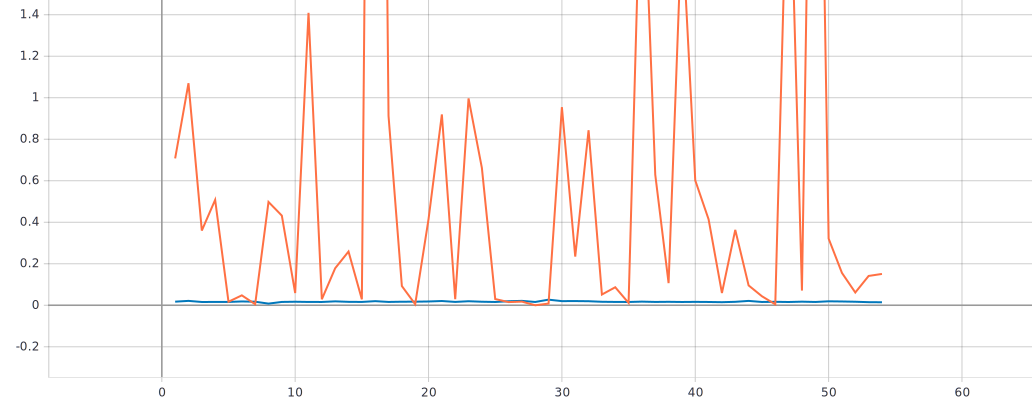

In [ ]:
from IPython.display import SVG
SVG("5layer_withoutealrystop.svg")


>The graph below showing us the <font color=red>validate error</font> and <font color=blue>training error</font> with the average value of train loss : 0.197  , "validate poit loss" : 0.149 . However, the validate error is less than the captured variance but the training error is showing good result which is around the captured variance. (Note, we are still reporting the result on the first output with the variance of **0.209**). So the rest of the models will be trained by early stop active in the program. 

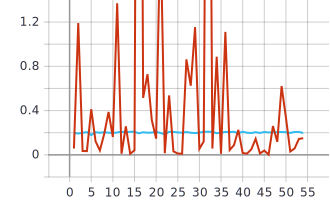

In [ ]:
SVG("5-layer_withstop.svg")

>Running the program for 3 layer and 2 layer the follwing result is reported <br>
- 3-layer train loss : 0.204  , "validate poit loss" : 0.179 
- 2_layer train loss : 0.207  , "validate poit loss" : 0.345 <br>
Hence, so far it could be concluded that the best regressor would be 3-layer network as the train error and validate error are both close to each other which is showing the robustness and close to expected variation of the out put. However, we more tuning we might be able to get to the better regressor. 
Another idea is playing with the regularizer . In this current program , both l-2 regulizer and Drop out layer is used. For furthur experiment on hyper tuning , the Drop out layers will be turned off in the 3-layer network. <br>
<br>
The result for 3_layer NN without any drop out layer is recorded as 0.208 ,0.250 for training and validate respectively. Still , the winner is 3_layer with Drop out layer. 
<br><br>
The decision about the activation function is also a hyperparameter. In the next stage the current leaky_Relu activation function is tweaked to Relu function. The reported result is quite interesting as 0.206 for the training  , 0.094 for the validate is repoted. the graph below shows that the this network with Relu activation function is less spiky than the network with Leaky_Relu. 


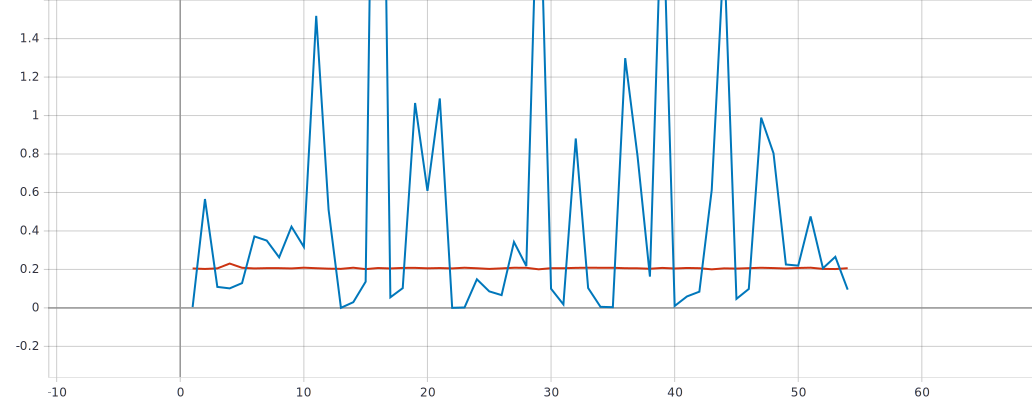

In [ ]:
SVG("3_layer_Relu.svg")

There are alot could be done for hyperparameter tuning via cross validation and training and actually for very sensetive cases all of them should be tried out. Among them searching for proper learning rate , testing different optimizers with their parameters , etc . are the most important ones. In this study the learning rate of 0.01 with adam optimizer with prametres Beta_1 : 0.9 and Beta_2 : .999 is used. As it is a small data set maybe changing this parameters would not give us better result and just might be just helpful to the convergence which is not the matter in this study. The dictionaty object in trauning block is to collect the training and validate loss for different classifiers. However , tensorboard is giving graph visualization both individually and together for the purpose of comparison. So, The 3_layer Network with Relu activation function and Drop out layer is chosen as the best classifier and Now we could train all algorithm feeding with whole dataset. (No test/ validate point) and the loss is 0.20849326 . 


# Result <br>
> The same process is doing for other outputs. and th etable below is showig the results. The result came through different initialization and the most acceptable one is reported. and the traioned model based on the best structure is saved via  **tf.saver()** . This function gives the user the ability to have the parameters of the model saved after training and tuning. Table below shows wich structure is suitable for each outcome based on our tuning. 

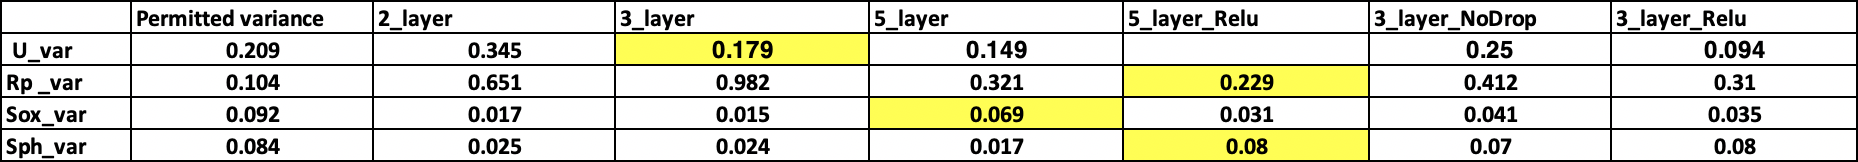

In [ ]:
from IPython.display import display, Image
display(Image(filename='Results.png'))

#Summary<br>
> In this study the prediction of 4 output related to Plasma Etching Process was of intereset based on 6 features. The data was collected through experimental design and just for one set of experiments, the replication was done. So, the genralization error of the trained regressor should be around the expected variance of each outcome. To find the best Network Structure, some shalow and semi_deep networks; with various stucture of The option of existance of Drop out layer and Relu vs Leaky_Relu activation functions, were tested via All vs one cross validation and the best network is chosen for each of outcomes based on the average error over all validate points. Also, as we had a knowledge of expected generalization variance, in order to avoid overfitting the early stop was put on training session.  TensorFlow is used to structure the networks and TensorBoard is used for visualization. 
<br>
For furthur study , it is suggested to have a random search around the other hyperparameters (learning rate, optimizers , regularizations, etc). Also, however the average loss of the cross validation errors are close to expected errors, as the graph shows the validation errors are too spiky and the variance should be moderate a little bit. 

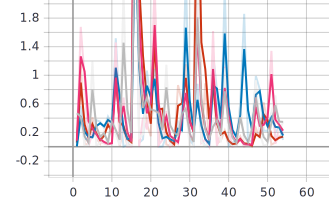

In [ ]:
SVG("validate_error_variance.svg")

> The graph above is showing the valiate errors for predicting the first output "U" . Each color is associated with one of the tested networks , however , all of them are almost variant at the sam erange the <font color=blue>blue line</font> which is illustrating the validate errors over different folds of cross_validation for 3_layer network (with Drop-out and Leaky_Relu activation function and L2_regularization), seems more steady. <br>
The python file contains all the codes including preprocessing, different structure and training and test Sessions.  